In [16]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import History, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from time import time
from tensorflow.keras.callbacks import TensorBoard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [3]:
if K.image_data_format() == 'channels_last':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [4]:
def preprocess_input_vgg(x):
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]


In [5]:
vgg16 = VGG16(weights='imagenet')

x  = vgg16.get_layer('fc2').output
prediction = Dense(2, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

In [6]:
# Freeze All Layers Except Bottleneck Layers for Fine-Tuning

for layer in model.layers:
    if layer.name in ['predictions']:
        continue
    layer.trainable = False


df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory='data/train',
                                                    target_size=[img_width, img_height],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
validation_generator = validation_datagen.flow_from_directory(directory='data/validation',
                                                              target_size=[img_width, img_height],
                                                              batch_size=batch_size,
                                                              class_mode='categorical')


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [7]:
sgd = SGD(lr=1e-4, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
tensorboard = TensorBoard(log_dir="logs\{}".format(time()))
#tensorboard --logdir logs\

In [9]:
# Compile with Adam Optimizer and a Small Learning Rate
# model.compile(optimizer='nadam',
#                   loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
#                   metrics=['accuracy'])

In [10]:
# top_weights_path = 'TFwCAandDO_10epoch_0.9705acc.h5'
# callbacks_list = [
#         ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
#         EarlyStopping(monitor='val_acc', patience=5, verbose=0)]

In [11]:
# Do Fine-Tuning
# model.fit_generator(train_generator,
#                     steps_per_epoch=16,
#                     epochs=10,
#                     validation_data=validation_generator,
#                     validation_steps=32);

In [12]:
history=model.fit_generator(train_generator, steps_per_epoch=2000 // batch_size, epochs=10,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        callbacks=[tensorboard])

Epoch 1/10
125/125 [==============================] - 533s 4s/step - loss: 0.2348 - accuracy: 0.9005 - val_loss: 0.0809 - val_accuracy: 0.9712
Epoch 2/10
125/125 [==============================] - 512s 4s/step - loss: 0.1268 - accuracy: 0.9485 - val_loss: 0.0704 - val_accuracy: 0.9750
Epoch 3/10
125/125 [==============================] - 511s 4s/step - loss: 0.0974 - accuracy: 0.9630 - val_loss: 0.0643 - val_accuracy: 0.9775
Epoch 4/10
125/125 [==============================] - 512s 4s/step - loss: 0.0912 - accuracy: 0.9655 - val_loss: 0.0612 - val_accuracy: 0.9800
Epoch 5/10
125/125 [==============================] - 511s 4s/step - loss: 0.0842 - accuracy: 0.9680 - val_loss: 0.0568 - val_accuracy: 0.9787
Epoch 6/10
125/125 [==============================] - 511s 4s/step - loss: 0.0757 - accuracy: 0.9685 - val_loss: 0.0543 - val_accuracy: 0.9812
Epoch 7/10
125/125 [==============================] - 510s 4s/step - loss: 0.0852 - accuracy: 0.9635 - val_loss: 0.0538 - val_accuracy: 0.9812

In [25]:
# Save trained weight                   
model.save_weights('TFwCAandDO_10epoch_0.9705acc.h5')

model_json_final = model.to_json()
with open("TFwCAandDO_10epoch_0.9705acc.json", "w") as json_file:
    json_file.write(model_json_final)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


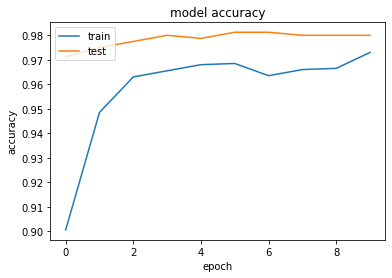

In [18]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

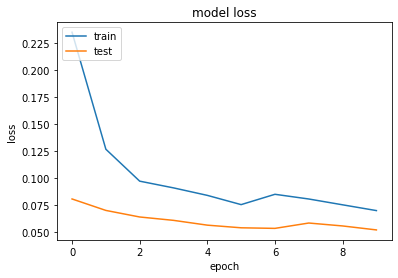

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

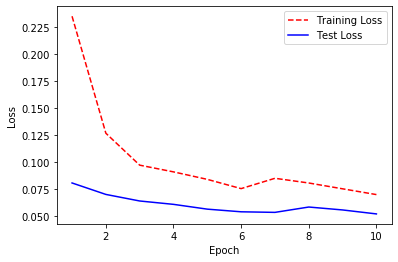

In [21]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

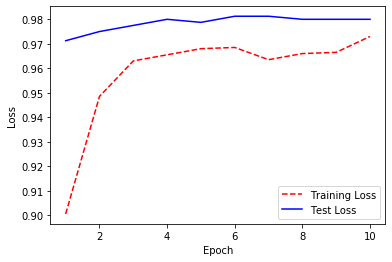

In [22]:
# Get training and test acc histories
training_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [28]:
with open('\logs', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

PermissionError: [Errno 13] Permission denied: '\\logs'